## Udacity Nano degree - Capstone Project 

### Implementation


This project tries to identify pneumonia chest x-ray images from normal ones. Further more it tries to classify whether the pneumonia is caused by bacteria or virus. It uses transfer learning, a highly effective technique in image classification.  It explores a few of the highly successful CNN architectures: Xception, Resnet 50, Inception V2, Inception V3 and use them for pneumonia classification. 

The steps are below: 
* Pre-process data
* Use each of the pretrained models to extract features on train, validation and test dataset. Store the extracted features in separate files; 
* Using the extracted features as input, build a top layer model; 
* Fit and train the top layer model on training and validating dataset to get the best weights. Apply early stopping and model checkpoint to keep track of and save the best weights;
* With features extracted in step 2 as input and the weights obtained in step 4, run the model on the test sets and output predictions.
* Obtain accuracy, specificity and sensitivity score from the results from step 5 and choose the best CNN architecture
* Test the model on more images. For example, images from the internet

In [1]:
#set numpy seed before start 
from numpy.random import seed
seed(1)

In [37]:
import os
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras import backend as K
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from keras import backend
from keras.preprocessing import image
import matplotlib
%matplotlib inline 
import matplotlib.image as mpimg
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import util
from time import gmtime, strftime
from keras.models import load_model

##### Download the dataset

Original dataset can be downloaded form [here](https://s3.us-east-2.amazonaws.com/chest-xay/chest_xray_original_07_23_2018.zip) (File size: 1.2 gb)

Pre-orgnized data can be downloaded from [here](https://s3.us-east-2.amazonaws.com/chest-xay/chest_xray.zip)  (File size: 1.2 gb)


##### Reorgnizing the data

In [ ]:
#only run this step from the original dataset
util.move_files() 

Re-orgnized data can be downloaded from [here](https://s3.us-east-2.amazonaws.com/chest-xay/chest_xray.zip)

Now your folder structure should have been changed as illustrated below

Before                     |  After
:-------------------------:|:-------------------------:
![](https://s3.us-east-2.amazonaws.com/chest-xay/original.png)  |  ![](https://s3.us-east-2.amazonaws.com/chest-xay/re-orgnized.png)

In [47]:
total_counts = 0
final_count = 0
for cat in['train', 'val', 'test']:
    total_counts = 0
    for cls in ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRAL']:
        dir = './chest_xray/{0}/{1}'.format(cat, cls)
        total_count = len([name for name in os.listdir(dir) if name.endswith('.jpeg') and os.path.isfile(os.path.join(dir, name)) ]) 
        total_counts += total_count
        print('In {0} dataset, there are {1: d} {2} images'.format(cat, total_count,  cls))
    
    final_count += total_counts
    print('\n total in {0} there are {1} images \n'.format(cat, total_counts))

print('\n Altogether there are {0} images \n'.format(final_count))


In train dataset, there are  1079 NORMAL images
In train dataset, there are  2034 PNEUMONIA_BACTERIA images
In train dataset, there are  1073 PNEUMONIA_VIRAL images

 total in train there are 4186 images 

In val dataset, there are  270 NORMAL images
In val dataset, there are  504 PNEUMONIA_BACTERIA images
In val dataset, there are  272 PNEUMONIA_VIRAL images

 total in val there are 1046 images 

In test dataset, there are  234 NORMAL images
In test dataset, there are  242 PNEUMONIA_BACTERIA images
In test dataset, there are  148 PNEUMONIA_VIRAL images

 total in test there are 624 images 


 Altogether there are 5856 images 



##### Pre-process the Data

Before that, we define some parameters that will be used throughout the project, for example, the intended target image size, number of epoches, batch size, directory paths where feature files, weights and history plots will be saved.


In [26]:
img_width, img_height = 224, 224
train_data_dir = 'chest_xray/train'
validation_data_dir = 'chest_xray/val'
test_data_dir = 'chest_xray/test'
learning_rate = 0.001
dropout_rate = 0.2

train_feature_file = 'saved_features/{0}/{1}/train_features.npy'
validation_feature_file = 'saved_features/{0}/{1}/validation_features.npy'
test_feature_file = 'saved_features/{0}/{1}/test_features.npy'
saved_model_weights_path = 'saved_weights/{0}/{1}/model.h5'
saved_history_path = 'history/{0}/{1}/plot_{2}.png'

# number of epochs to train top model
epochs = 200
# batch size used by flow_from_directory and predict_generator
batch_size = 16

In [27]:
# instantiate ImageDataGenerator. Normalize images by dividing every pixel by 255
datagen = ImageDataGenerator(rescale=1. / 255)


In the next few blocks we will define a few general purpose methods for later use. a. make sure we have the folder structure in place so we can save the features, weights and supporting files; b. define and create a list of models, Xception, InceptionResNetV2, InceptionV3 and ResNet50


In [4]:
# make sure we have the folder structure in place, if not create the folder 
def check_file_folder(file_path):
    directory = os.path.dirname(file_path)
    os.makedirs(directory, exist_ok=True)


In [4]:
# instantiate a pretrained CNN model we will be using. All of them will have the top layer removed
def pretrained_model(model_name):
    return {
        'Xception': Xception(include_top=False, weights='imagenet'),
        'InceptionResNetV2': InceptionResNetV2(weights='imagenet', include_top=False),
        'InceptionV3': InceptionV3(weights='imagenet', include_top=False),
        'ResNet50': ResNet50(weights='imagenet', include_top=False),
    }[model_name]

In [21]:
def get_bottleneck_features(dir, feature_file, pretrained_model, target_width=224, target_height=224):
    
    check_file_folder(feature_file)
    generator = datagen.flow_from_directory(
        dir,
        target_size=(target_width, target_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_samples = len(generator.filenames)

    predict_size = int(math.ceil(nb_samples / batch_size))

    features_train = pretrained_model.predict_generator(generator, predict_size)

    np.save(feature_file, features_train)
    print('feature extracted and saved in ', feature_file)


##### Extract bottleneck features

Now we are ready to use the data generator for training images, and run them on our chosen model to save the bottleneck features. We do this on all the training, testing, and validation images.

In [28]:
def extract_features(model_name, current_size = '224_224'):
    pretrain_model = pretrained_model(model_name)
    get_bottleneck_features(train_data_dir, train_feature_file.format(model_name, current_size), pretrain_model)
    get_bottleneck_features(validation_data_dir, validation_feature_file.format(model_name, current_size), pretrain_model)
    get_bottleneck_features(test_data_dir, test_feature_file.format(model_name, current_size), pretrain_model)

In [29]:
model_names = ['InceptionResNetV2', 'ResNet50', 'Xception', 'InceptionV3']

for mode_name in model_names:
    current_model_name = mode_name
    print('extract features model name ', current_model_name)
    extract_features(current_model_name)

extract features model name  InceptionResNetV2
Found 4186 images belonging to 3 classes.
feature extracted and saved in  saved_features/InceptionResNetV2/224_224/train_features.npy
Found 1046 images belonging to 3 classes.
feature extracted and saved in  saved_features/InceptionResNetV2/224_224/validation_features.npy
Found 624 images belonging to 3 classes.
feature extracted and saved in  saved_features/InceptionResNetV2/224_224/test_features.npy
extract features model name  ResNet50
Found 4186 images belonging to 3 classes.
feature extracted and saved in  saved_features/ResNet50/224_224/train_features.npy
Found 1046 images belonging to 3 classes.
feature extracted and saved in  saved_features/ResNet50/224_224/validation_features.npy
Found 624 images belonging to 3 classes.
feature extracted and saved in  saved_features/ResNet50/224_224/test_features.npy
extract features model name  Xception
Found 4186 images belonging to 3 classes.
feature extracted and saved in  saved_features/Xcept

Extracting features will take a long time. Running on CPU, mac Os High Sierra (16 gb memory, 2.2 ghz processor), it takes about 6 to 7 hours. 

You may download the saved features from the following link:

[saved_features.zip](https://s3.us-east-2.amazonaws.com/chest-xay/saved_features.zip): (File size: 3.4 gb)

The zip included all of the test, train and validation bottleneck features trained using `InceptionResNetV2`, `ResNet50`, `Xception`, `InceptionV3`.

The following is an unzipped view:

![saved features folder structure](https://s3.us-east-2.amazonaws.com/chest-xay/saved_features+screenshot.png)

With the bottleneck features saved, now we're ready to create and train the top model. The function is defined in `train_top_model()`. The top CNN architectures is defined in `get_top_model`. It has a `GlobalAveragePooling2D` layer with the extracted bottleneck featuers as input and a full connected layer with `softmax` activation for final prediction. A dropout layer is used to address the overfitting problem.


In [33]:
def get_top_model(data, num_classes, dr=.2):
    #print(dropout_rate)
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=data.shape[1:]))
    model.add(Dropout(dr))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In order to train the top model, we need the class labels for each of the training/validation samples. We use a data generator. We also need to convert the labels to categorical vectors. This is defined in the `get_categorical_labels` method

In [22]:
def get_categorical_labels(dir, feature_file, target_width=224, target_height=224):
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        dir,
        target_size=(target_width, target_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    num_classes = len(generator_top.class_indices)
    data = np.load(feature_file)
    #print('data load from ' ,feature_file)
    labels = generator_top.classes
    labels = to_categorical(labels, num_classes=num_classes)
    return data, labels, num_classes

In [34]:
def plot_history(history, model_name, current_size='224_224'):
    check_file_folder(saved_history_path.format(model_name, current_size,  strftime("%Y-%m-%d %H:%M:%S", gmtime())))
    plt.figure()

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('{0} model accuracy'.format(model_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('{0} model loss'.format(model_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.tight_layout()
    plt.savefig(saved_history_path.format(model_name, current_size,  strftime("%Y-%m-%d %H:%M:%S", gmtime())))

Finally the method `train_top_model`. It starts by getting the needed data and target labels for training and validation data set, then it creates the CNN top layer model and compiles. It use model checkpointing to save the model that attains the best validation loss. Early stopping is also used so that once there is no improvement, the training and validation process will end.

It's always better to see how well a model gets trained. So at the end it graphs the training history. The graph is saved offline.

In [52]:
def train_top_model(model_weights_path, train_feature_path, val_feature_path, train_dir, val_dir, model_name, current_size='224_224', lr=0.001):
    target_width = 224
    target_height = 224
    check_file_folder(saved_model_weights_path.format(model_name, current_size))
    if current_size == '299_229':
        target_width = 299
        target_height = 299
        
    train_data, train_labels, num_classes = get_categorical_labels(train_dir, train_feature_path.format(model_name, current_size, target_width, target_height))
    validation_data, validation_labels, num_classes = get_categorical_labels(val_dir,
                                                                             val_feature_path.format(model_name, current_size, target_width, target_height))

    #print(model_weights_path, train_feature_path, val_feature_path)
    model = get_top_model(train_data, num_classes)
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
    
    if lr != learning_rate:
        print('current learning rate is ', lr)
        
    model.compile(optimizer=optimizers.Adam(lr=lr),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    checkpointer = ModelCheckpoint(filepath=model_weights_path, verbose=1, save_best_only=True,
                                   save_weights_only=False, )
    callbacks_list = [earlystop, checkpointer]
    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels), callbacks=callbacks_list)

    model.save_weights(saved_model_weights_path.format(model_name, current_size))

    plot_history(history, model_name, current_size)

The code that iterates through the models and does the training.

In [36]:
model_names = ['ResNet50', 'Xception', 'InceptionV3','InceptionResNetV2',]
current_size = '224_224' 
for current_model_name in model_names:
    top_model_weights_path = saved_model_weights_path.format(current_model_name, current_size)
    print(current_model_name)
    train_top_model(model_weights_path=top_model_weights_path,
                    train_feature_path=train_feature_file,
                    val_feature_path=validation_feature_file,
                    train_dir=train_data_dir,
                    val_dir=validation_data_dir, model_name=current_model_name)

ResNet50
Found 4186 images belonging to 3 classes.
data load from  saved_features/ResNet50/224_224/train_features.npy
Found 1046 images belonging to 3 classes.
data load from  saved_features/ResNet50/224_224/validation_features.npy
0.2
Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 52s 12ms/step - loss: 1.0759 - acc: 0.4594 - val_loss: 1.0189 - val_acc: 0.4818

Epoch 00001: val_loss improved from inf to 1.01892, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 2/200
4186/4186 [==============================] - 5s 1ms/step - loss: 1.0094 - acc: 0.5108 - val_loss: 0.9749 - val_acc: 0.5736

Epoch 00002: val_loss improved from 1.01892 to 0.97489, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 3/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.9774 - acc: 0.5325 - val_loss: 0.9492 - val_acc: 0.4904

Epoch 00003: val_loss improved from 0.97489 to 0.94925, saving model to saved_weights/


Epoch 00036: val_loss did not improve from 0.72433
Epoch 37/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.7564 - acc: 0.6665 - val_loss: 0.7317 - val_acc: 0.6625

Epoch 00037: val_loss did not improve from 0.72433
Epoch 38/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.7522 - acc: 0.6720 - val_loss: 0.7626 - val_acc: 0.6530

Epoch 00038: val_loss did not improve from 0.72433
Epoch 39/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.7589 - acc: 0.6639 - val_loss: 0.7213 - val_acc: 0.6769

Epoch 00039: val_loss improved from 0.72433 to 0.72126, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 40/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.7624 - acc: 0.6622 - val_loss: 0.7076 - val_acc: 0.6807

Epoch 00040: val_loss improved from 0.72126 to 0.70760, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 41/200
4186/4186 [==============================] - 5s 1ms/step - lo

4186/4186 [==============================] - 5s 1ms/step - loss: 0.7128 - acc: 0.6868 - val_loss: 0.6587 - val_acc: 0.7266

Epoch 00076: val_loss improved from 0.66071 to 0.65874, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 77/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.7069 - acc: 0.6945 - val_loss: 0.6577 - val_acc: 0.7266

Epoch 00077: val_loss improved from 0.65874 to 0.65767, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 78/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.7115 - acc: 0.6880 - val_loss: 0.6569 - val_acc: 0.7046

Epoch 00078: val_loss improved from 0.65767 to 0.65688, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 79/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.7038 - acc: 0.6971 - val_loss: 0.6580 - val_acc: 0.7314

Epoch 00079: val_loss did not improve from 0.65688
Epoch 80/200
4186/4186 [==============================] - 5s 1ms/step - loss: 

4186/4186 [==============================] - 5s 1ms/step - loss: 0.6838 - acc: 0.7009 - val_loss: 0.6575 - val_acc: 0.6960

Epoch 00115: val_loss did not improve from 0.63204
Epoch 116/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6836 - acc: 0.7007 - val_loss: 0.6300 - val_acc: 0.7457

Epoch 00116: val_loss improved from 0.63204 to 0.62996, saving model to saved_weights/ResNet50/224_224/model.h5
Epoch 117/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6769 - acc: 0.6968 - val_loss: 0.6428 - val_acc: 0.7438

Epoch 00117: val_loss did not improve from 0.62996
Epoch 118/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6870 - acc: 0.7059 - val_loss: 0.6321 - val_acc: 0.7380

Epoch 00118: val_loss did not improve from 0.62996
Epoch 119/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6831 - acc: 0.6992 - val_loss: 0.6270 - val_acc: 0.7400

Epoch 00119: val_loss improved from 0.62996 to 0.62701, sav


Epoch 00155: val_loss did not improve from 0.61267
Epoch 156/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6592 - acc: 0.7155 - val_loss: 0.6183 - val_acc: 0.7275

Epoch 00156: val_loss did not improve from 0.61267
Epoch 157/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6660 - acc: 0.7083 - val_loss: 0.6263 - val_acc: 0.7543

Epoch 00157: val_loss did not improve from 0.61267
Epoch 158/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6641 - acc: 0.7117 - val_loss: 0.6223 - val_acc: 0.7218

Epoch 00158: val_loss did not improve from 0.61267
Epoch 159/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6672 - acc: 0.7164 - val_loss: 0.6212 - val_acc: 0.7467

Epoch 00159: val_loss did not improve from 0.61267
Epoch 160/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6567 - acc: 0.7181 - val_loss: 0.6169 - val_acc: 0.7380

Epoch 00160: val_loss did not improve from 0.61267
Epo

4186/4186 [==============================] - 6s 1ms/step - loss: 0.6413 - acc: 0.7222 - val_loss: 0.6074 - val_acc: 0.7333

Epoch 00197: val_loss did not improve from 0.59689
Epoch 198/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.6476 - acc: 0.7289 - val_loss: 0.6212 - val_acc: 0.7084

Epoch 00198: val_loss did not improve from 0.59689
Epoch 199/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6519 - acc: 0.7205 - val_loss: 0.6009 - val_acc: 0.7400

Epoch 00199: val_loss did not improve from 0.59689
Epoch 200/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.6517 - acc: 0.7160 - val_loss: 0.6241 - val_acc: 0.7094

Epoch 00200: val_loss did not improve from 0.59689
Xception
Found 4186 images belonging to 3 classes.
data load from  saved_features/Xception/224_224/train_features.npy
Found 1046 images belonging to 3 classes.
data load from  saved_features/Xception/224_224/validation_features.npy
0.2
Train on 4186 samples,

4186/4186 [==============================] - 5s 1ms/step - loss: 0.3742 - acc: 0.8387 - val_loss: 0.4842 - val_acc: 0.7906

Epoch 00037: val_loss did not improve from 0.45597
Epoch 38/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.3819 - acc: 0.8313 - val_loss: 0.4808 - val_acc: 0.7830

Epoch 00038: val_loss did not improve from 0.45597
Epoch 39/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.3830 - acc: 0.8266 - val_loss: 0.4690 - val_acc: 0.7925

Epoch 00039: val_loss did not improve from 0.45597
Epoch 40/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.3717 - acc: 0.8292 - val_loss: 0.4777 - val_acc: 0.7878

Epoch 00040: val_loss did not improve from 0.45597
Epoch 41/200
4186/4186 [==============================] - 5s 1ms/step - loss: 0.3783 - acc: 0.8361 - val_loss: 0.5018 - val_acc: 0.7868

Epoch 00041: val_loss did not improve from 0.45597
Epoch 42/200
4186/4186 [==============================] - 6s 1ms/step - l

4186/4186 [==============================] - 6s 1ms/step - loss: 0.4929 - acc: 0.7845 - val_loss: 0.5047 - val_acc: 0.7839

Epoch 00011: val_loss did not improve from 0.48217
Epoch 12/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4820 - acc: 0.7888 - val_loss: 0.5088 - val_acc: 0.7600

Epoch 00012: val_loss did not improve from 0.48217
Epoch 13/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4651 - acc: 0.7957 - val_loss: 0.5019 - val_acc: 0.7859

Epoch 00013: val_loss did not improve from 0.48217
Epoch 14/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4835 - acc: 0.7888 - val_loss: 0.5011 - val_acc: 0.7964

Epoch 00014: val_loss did not improve from 0.48217
Epoch 15/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4666 - acc: 0.8008 - val_loss: 0.5024 - val_acc: 0.7811

Epoch 00015: val_loss did not improve from 0.48217
Epoch 16/200
4186/4186 [==============================] - 6s 1ms/step - l


Epoch 00053: val_loss did not improve from 0.46357
Epoch 54/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4421 - acc: 0.8060 - val_loss: 0.6523 - val_acc: 0.7094

Epoch 00054: val_loss did not improve from 0.46357
Epoch 55/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4540 - acc: 0.8070 - val_loss: 0.4983 - val_acc: 0.7964

Epoch 00055: val_loss did not improve from 0.46357
Epoch 56/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4367 - acc: 0.8115 - val_loss: 0.4974 - val_acc: 0.7964

Epoch 00056: val_loss did not improve from 0.46357
Epoch 57/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4493 - acc: 0.8058 - val_loss: 0.5071 - val_acc: 0.7973

Epoch 00057: val_loss did not improve from 0.46357
Epoch 58/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4410 - acc: 0.8139 - val_loss: 0.5806 - val_acc: 0.7772

Epoch 00058: val_loss did not improve from 0.46357
Epoch 59


Epoch 00063: val_loss did not improve from 0.49236
Epoch 64/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4983 - acc: 0.7833 - val_loss: 0.6501 - val_acc: 0.7361

Epoch 00064: val_loss did not improve from 0.49236
Epoch 65/200
4186/4186 [==============================] - 6s 2ms/step - loss: 0.5238 - acc: 0.7771 - val_loss: 0.5489 - val_acc: 0.7562

Epoch 00065: val_loss did not improve from 0.49236
Epoch 66/200
4186/4186 [==============================] - 6s 2ms/step - loss: 0.5129 - acc: 0.7833 - val_loss: 0.5978 - val_acc: 0.7610

Epoch 00066: val_loss did not improve from 0.49236
Epoch 67/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4945 - acc: 0.7850 - val_loss: 0.4888 - val_acc: 0.7859

Epoch 00067: val_loss improved from 0.49236 to 0.48881, saving model to saved_weights/InceptionResNetV2/224_224/model.h5
Epoch 68/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4753 - acc: 0.7946 - val_loss: 0.6464 - val_ac

4186/4186 [==============================] - 6s 1ms/step - loss: 0.5101 - acc: 0.7817 - val_loss: 0.6234 - val_acc: 0.7438

Epoch 00107: val_loss did not improve from 0.48881
Epoch 108/200
4186/4186 [==============================] - 6s 2ms/step - loss: 0.4923 - acc: 0.7867 - val_loss: 0.5018 - val_acc: 0.7782

Epoch 00108: val_loss did not improve from 0.48881
Epoch 109/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.5104 - acc: 0.7864 - val_loss: 0.4966 - val_acc: 0.7839

Epoch 00109: val_loss did not improve from 0.48881
Epoch 110/200
4186/4186 [==============================] - 6s 1ms/step - loss: 0.4787 - acc: 0.7905 - val_loss: 0.5053 - val_acc: 0.7772

Epoch 00110: val_loss did not improve from 0.48881
Epoch 111/200
4186/4186 [==============================] - 6s 2ms/step - loss: 0.5078 - acc: 0.7802 - val_loss: 0.7457 - val_acc: 0.6405

Epoch 00111: val_loss did not improve from 0.48881
Epoch 112/200
4186/4186 [==============================] - 6s 1ms/ste

### Test the Model

Now we are ready to load the weights into the models and test them on the test set. We also define some methods to calculate accuracy, sensitivity, specificity and F1 score. 

Though the training outputs 3 labels: normal, pneumonia_bacteria, pneumonia_viral, the accuracy, sensitivity, specificity and F1 score are carried out as a single class / binary comparison of normal vs pneumonia, bacterial pneumonia vs otherwise, and viral pnenumonia vs otherwise. 



In [37]:
def sensitivity(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + backend.epsilon())

In [38]:
def specificity(y_true, y_pred):
    true_negatives = np.sum(np.round(np.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = np.sum(np.round(np.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + backend.epsilon())

The following method outputs all of our metrics, specificity, sensitivity, accuracy, f1_score, given an array of target labels and predictions. The F1_score assign equal weights to both sensitivity and specificity.

In [39]:
def get_evaluation_metrics(y_true, y_pred):
    specificity_score = specificity(y_true, y_pred)
    sensitivity_score = sensitivity(y_true, y_pred)
    sum_correct = np.sum(np.array(y_true == y_pred))
    total_preds = len(y_pred)
    accuracy = sum_correct / total_preds
    f_score = 2 * (specificity_score * sensitivity_score) / (specificity_score + sensitivity_score)
    return accuracy, specificity_score, sensitivity_score, f_score


Further more, we define the methods to output the metrics for the comparisons between normal vs pneumonia, specific types of pneumonia vs otherwise

In [40]:
#normal = 0, pneumonia_bacteria = 1, pneumonia_viral = 2

# if set result to positive (1) if result is greater than 0, otherwise negative (0)
def get_normal_vs_pneumonia_metrics(preds, targets):
    class_id_preds = np.argmax(preds, axis=-1)
    class_id_true = np.argmax(targets, axis=-1)

    pred_positive = class_id_preds > 0
    true_positive = class_id_true > 0
    return get_evaluation_metrics(true_positive.astype(int), pred_positive.astype(int))


# if set result to positive (1) if result is the same as the class we would like to use for positive (0), otherwise negative (0)
def get_pneumonia_vs_others(preds, targets, class_id):
    class_id_preds = np.argmax(preds, axis=-1)
    class_id_true = np.argmax(targets, axis=-1)

    pred_positive = class_id_preds == class_id
    true_positive = class_id_true == class_id
    return get_evaluation_metrics(true_positive.astype(int), pred_positive.astype(int))


Now run the model through the test dataset and checkout results:

In [56]:
def predict_test_set(test_dir, weights_path, test_features, train_dir, train_features, current_size='224_224'):
    target_width = img_width
    target_height = img_height
    if current_size == '299_229':
        target_width = 299
        target_height = 299
        print('target width, target height ', target_width, target_height)
    train_data, train_labels, num_classes = get_categorical_labels(train_dir, train_features, target_width, target_height)
    test_data, test_labels, num_classes = get_categorical_labels(test_dir, test_features, target_width, target_height)
    print('load weights from ', weights_path)
    model = get_top_model(train_data, num_classes)
    model.load_weights(weights_path)
    preds = model.predict(test_data, batch_size=batch_size)
    return preds, test_labels


In [42]:
for current_model_name in model_names:
    predictions, target_labels = predict_test_set(test_dir=test_data_dir,
                                                  weights_path=saved_model_weights_path.format(current_model_name, current_size),
                                                  test_features=test_feature_file.format(current_model_name, current_size),
                                                  train_dir=train_data_dir,
                                                  train_features=train_feature_file.format(current_model_name, current_size))

    
    print('\n Model Name ' + current_model_name + ' img size ' + str(img_height))

    print('\nAccuracy, Specificity, Sensitivity, F1-Score\n')

    accuracy, specificity_score, sensitivity_score, fscore = get_normal_vs_pneumonia_metrics(predictions, target_labels)
    print('Normal vs pneumonia, {0:.4f}, {1:.4f} , {2:.4f}, {3:.4f}'.format(accuracy, specificity_score,
                                                                                     sensitivity_score, fscore))

    accuracy, specificity_score, sensitivity_score, fscore = get_pneumonia_vs_others(predictions, target_labels, 1)
    print('Bacterial vs others metrics, {0:.4f},  {1:.4f} , {2:.4f}, {3:.4f}'.format(accuracy,
                                                                                              specificity_score,
                                                                                              sensitivity_score,
                                                                                              fscore))

    accuracy, specificity_score, sensitivity_score, fscore = get_pneumonia_vs_others(predictions, target_labels, 2)
    print(
        'Viral vs others metrics, {0:.4f} , {1:.4f} , {2:.4f}, {3:.4f}'.format(accuracy,
                                                                                        specificity_score,
                                                                                        sensitivity_score, fscore))



Found 4186 images belonging to 3 classes.
data load from  saved_features/ResNet50/224_224/train_features.npy
Found 624 images belonging to 3 classes.
data load from  saved_features/ResNet50/224_224/test_features.npy
0.2

 Model Name ResNet50 img size 224

Accuracy, Specificity, Sensitivity, F1-Score

Normal vs pneumonia, 0.8478, 0.6795 , 0.9487, 0.7918
Bacterial vs others metrics, 0.6731,  0.5052 , 0.9380, 0.6567
Viral vs others metrics, 0.7965 , 0.9916 , 0.1689, 0.2887
Found 4186 images belonging to 3 classes.
data load from  saved_features/Xception/224_224/train_features.npy
Found 624 images belonging to 3 classes.
data load from  saved_features/Xception/224_224/test_features.npy
0.2

 Model Name Xception img size 224

Accuracy, Specificity, Sensitivity, F1-Score

Normal vs pneumonia, 0.8830, 0.7137 , 0.9846, 0.8275
Bacterial vs others metrics, 0.8846,  0.8377 , 0.9587, 0.8941
Viral vs others metrics, 0.8542 , 0.8950 , 0.7230, 0.7998
Found 4186 images belonging to 3 classes.
data loa

##### Choose the model and refinement

From the above, `InceptionResNetV2` outperforms the reset. From this point on, we will focus on and fine tune `InceptionResNetV2`. 

##### Extract feature using a different target image size

In [46]:
def get_CNN_bottleneck_features(dir_path, feature_file, pretrained_model, target_width, target_height):
    check_file_folder(feature_file)
    generator = datagen.flow_from_directory(
        dir_path,
        target_size=(target_width, target_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_samples = len(generator.filenames)
    predict_size = int(math.ceil(nb_samples / batch_size))
    features_train = pretrained_model.predict_generator(generator, predict_size)
    np.save(feature_file, features_train)
    print('feature extracted and saved in ', feature_file)

In [48]:
current_size = '299_299'
current_model_name = 'InceptionResNetV2'
inceptionresnet_model = pretrained_model(current_model_name)
get_CNN_bottleneck_features(train_data_dir, train_feature_file.format(current_model_name, current_size), inceptionresnet_model, 299, 299)
get_CNN_bottleneck_features(validation_data_dir, validation_feature_file.format(current_model_name, current_size), inceptionresnet_model, 299, 299)
get_CNN_bottleneck_features(test_data_dir, test_feature_file.format(current_model_name, current_size), inceptionresnet_model, 299, 299)

Found 4186 images belonging to 3 classes.
feature extracted and saved in  saved_features/InceptionResNetV2/299_299/train_features.npy
Found 1046 images belonging to 3 classes.
feature extracted and saved in  saved_features/InceptionResNetV2/299_299/validation_features.npy
Found 624 images belonging to 3 classes.
feature extracted and saved in  saved_features/InceptionResNetV2/299_299/test_features.npy


Train and fit the top model we created earlier with the features we just extracted

In [53]:
top_model_weights_path = saved_model_weights_path.format(current_model_name, current_size)
print('train top model with target size ', current_model_name, current_size)
train_top_model(model_weights_path=top_model_weights_path,
                train_feature_path=train_feature_file,
                val_feature_path=validation_feature_file,
                train_dir=train_data_dir,
                val_dir=validation_data_dir, model_name=current_model_name, current_size = current_size, lr=0.0005)

train top model with target size  InceptionResNetV2 299_299
Found 4186 images belonging to 3 classes.
data load from  saved_features/InceptionResNetV2/299_299/train_features.npy
Found 1046 images belonging to 3 classes.
data load from  saved_features/InceptionResNetV2/299_299/validation_features.npy
0.2
current learning rate is  0.0005
Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 67s 16ms/step - loss: 0.8325 - acc: 0.6307 - val_loss: 0.6462 - val_acc: 0.7333

Epoch 00001: val_loss improved from inf to 0.64622, saving model to saved_weights/InceptionResNetV2/299_299/model.h5
Epoch 2/200
4186/4186 [==============================] - 9s 2ms/step - loss: 0.6324 - acc: 0.7396 - val_loss: 0.5782 - val_acc: 0.7591

Epoch 00002: val_loss improved from 0.64622 to 0.57818, saving model to saved_weights/InceptionResNetV2/299_299/model.h5
Epoch 3/200
4186/4186 [==============================] - 9s 2ms/step - loss: 0.5992 - acc: 0.7401 - va

4186/4186 [==============================] - 8s 2ms/step - loss: 0.4502 - acc: 0.8072 - val_loss: 0.4708 - val_acc: 0.7878

Epoch 00078: val_loss did not improve from 0.45274
Epoch 79/200
4186/4186 [==============================] - 7s 2ms/step - loss: 0.4502 - acc: 0.8027 - val_loss: 0.4548 - val_acc: 0.7973

Epoch 00079: val_loss did not improve from 0.45274
Epoch 80/200
4186/4186 [==============================] - 7s 2ms/step - loss: 0.4498 - acc: 0.8051 - val_loss: 0.4869 - val_acc: 0.7801

Epoch 00080: val_loss did not improve from 0.45274
Epoch 81/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.4459 - acc: 0.8060 - val_loss: 0.4613 - val_acc: 0.8021

Epoch 00081: val_loss did not improve from 0.45274
Epoch 82/200
4186/4186 [==============================] - 7s 2ms/step - loss: 0.4384 - acc: 0.8070 - val_loss: 0.4585 - val_acc: 0.7973

Epoch 00082: val_loss did not improve from 0.45274
Epoch 83/200
4186/4186 [==============================] - 7s 2ms/step - l

4186/4186 [==============================] - 9s 2ms/step - loss: 0.4329 - acc: 0.8043 - val_loss: 0.4578 - val_acc: 0.7992

Epoch 00163: val_loss did not improve from 0.44735
Epoch 164/200
4186/4186 [==============================] - 9s 2ms/step - loss: 0.4382 - acc: 0.8072 - val_loss: 0.4520 - val_acc: 0.8040

Epoch 00164: val_loss did not improve from 0.44735
Epoch 165/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.4476 - acc: 0.8065 - val_loss: 0.4584 - val_acc: 0.7992

Epoch 00165: val_loss did not improve from 0.44735
Epoch 166/200
4186/4186 [==============================] - 9s 2ms/step - loss: 0.4466 - acc: 0.8091 - val_loss: 0.4600 - val_acc: 0.7906

Epoch 00166: val_loss did not improve from 0.44735
Epoch 167/200
4186/4186 [==============================] - 9s 2ms/step - loss: 0.4455 - acc: 0.7989 - val_loss: 0.4589 - val_acc: 0.7983

Epoch 00167: val_loss did not improve from 0.44735
Epoch 168/200
4186/4186 [==============================] - 9s 2ms/ste

Run prediction on the test set and output relevant metrics

In [59]:
predictions, target_labels = predict_test_set(test_dir=test_data_dir,
                                                  weights_path=saved_model_weights_path.format(current_model_name, current_size),
                                                  test_features=test_feature_file.format(current_model_name, current_size),
                                                  train_dir=train_data_dir,
                                                  train_features=train_feature_file.format(current_model_name, current_size),
                                                  current_size = current_size)

    
print('\n Model Name ' + current_model_name + ' current size ' + current_size)

print('\nAccuracy, Specificity, Sensitivity, F1-Score\n')

accuracy, specificity_score, sensitivity_score, fscore = get_normal_vs_pneumonia_metrics(predictions, target_labels)
print('Normal vs pneumonia, {0:.4f}, {1:.4f} , {2:.4f}, {3:.4f}'.format(accuracy, specificity_score,
                                                                                 sensitivity_score, fscore))

accuracy, specificity_score, sensitivity_score, fscore = get_pneumonia_vs_others(predictions, target_labels, 1)
print('Bacterial vs others metrics, {0:.4f},  {1:.4f} , {2:.4f}, {3:.4f}'.format(accuracy,
                                                                                          specificity_score,
                                                                                          sensitivity_score,
                                                                                          fscore))

accuracy, specificity_score, sensitivity_score, fscore = get_pneumonia_vs_others(predictions, target_labels, 2)
print(
    'Viral vs others metrics, {0:.4f} , {1:.4f} , {2:.4f}, {3:.4f}'.format(accuracy,
                                                                                    specificity_score,
                                                                                    sensitivity_score, fscore))



Found 4186 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
load weights from  saved_weights/InceptionResNetV2/299_299/model.h5
0.2

 Model Name InceptionResNetV2 current size 299_299

Accuracy, Specificity, Sensitivity, F1-Score

Normal vs pneumonia, 0.9199, 0.8120 , 0.9846, 0.8900
Bacterial vs others metrics, 0.8878,  0.8351 , 0.9711, 0.8980
Viral vs others metrics, 0.8942 , 0.9496 , 0.7162, 0.8166


In [1]:
Output confusion matrix and print a classification report

SyntaxError: invalid syntax (<ipython-input-1-b5f0ca49e2e6>, line 1)

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRAL']
test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

labels = test_generator.classes
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(labels, y_pred))
print('Classification Report')
print(classification_report(labels, y_pred, target_names=target_names))



Found 624 images belonging to 3 classes.
Confusion Matrix
[[190  23  21]
 [  4 235   3]
 [  2  40 106]]
Classification Report
                    precision    recall  f1-score   support

            NORMAL       0.97      0.81      0.88       234
PNEUMONIA_BACTERIA       0.79      0.97      0.87       242
   PNEUMONIA_VIRAL       0.82      0.72      0.76       148

       avg / total       0.86      0.85      0.85       624



##### Predict Pneumonia from chest x-ray images

Images are found online 

In [41]:
def path_to_tensor(img_path, target_width, target_height):
    img = image.load_img(img_path, target_size=(target_width, target_height))
    # convert PIL.Image.Image type to 3D tensor with shape (target_width, target_height, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, target_width, target_height, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [55]:
def predict_images(model_name, current_size):
    result_output = ['NORMAL.', 'Bacterial Pneumonia', 'Viral Pneumonia']
    imgdir = 'chest-xray-sample-images'
    weights_path = saved_model_weights_path.format(model_name, current_size)
    InceptionResV2 = pretrained_model('InceptionResNetV2')
    model = None
    
    for img in os.listdir(imgdir):
        if img.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = imgdir + '/' + img
            img = mpimg.imread(img_path)
            imgplot = plt.imshow(img)
            plt.show()
            tensor = path_to_tensor(img_path, target_width=299, target_height=299)
            bottleneck_feature = InceptionResV2.predict(preprocess_input(tensor))
            if model is None:
                model = get_top_model(bottleneck_feature, 3)
                model.load_weights(weights_path)
                
            predicted_vector = model.predict(bottleneck_feature) 
            predict_prob = np.max(predicted_vector) * 100
            res = np.argmax(predicted_vector)
            print ('The result is {0} with a probability of {1:.2f}%'.format(result_output[res], predict_prob))


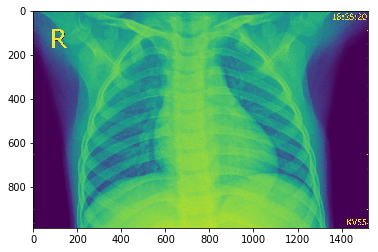

The result is Viral Pneumonia with a probability of 58.79%


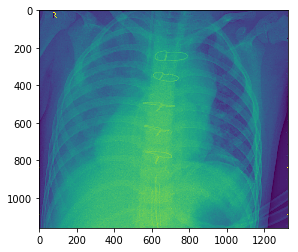

The result is Bacterial Pneumonia with a probability of 77.59%


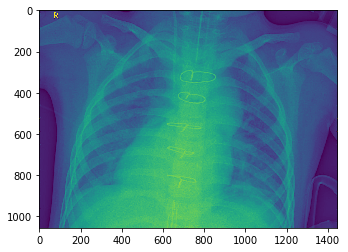

The result is Bacterial Pneumonia with a probability of 89.56%


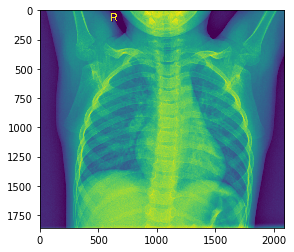

The result is NORMAL. with a probability of 99.97%


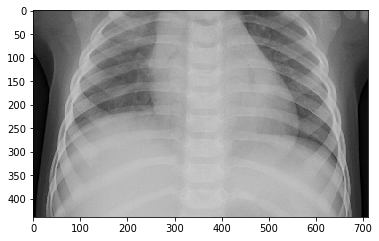

The result is Bacterial Pneumonia with a probability of 67.75%


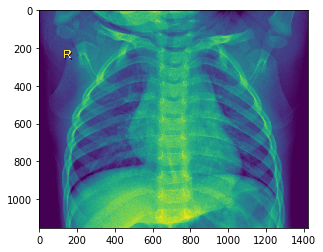

The result is NORMAL. with a probability of 99.60%


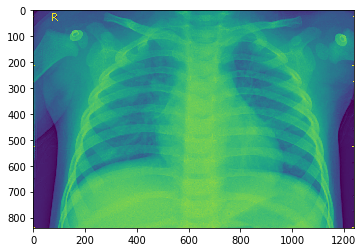

The result is Bacterial Pneumonia with a probability of 70.92%


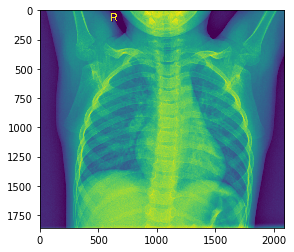

The result is NORMAL. with a probability of 99.97%


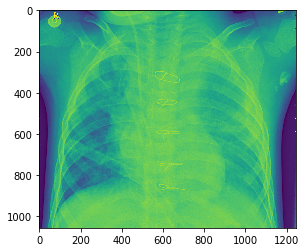

The result is Bacterial Pneumonia with a probability of 86.32%


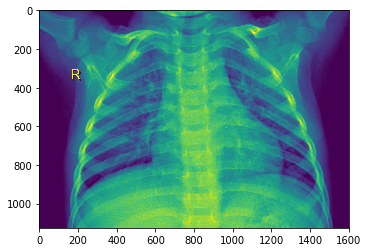

The result is NORMAL. with a probability of 84.10%


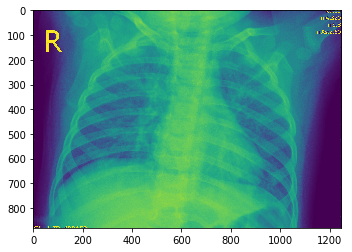

The result is Viral Pneumonia with a probability of 74.32%


In [56]:
current_model_name = 'InceptionResNetV2'
current_size = '299_299'
predict_images(current_model_name, current_size)